In [75]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [76]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [77]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [78]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [79]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [80]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [81]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [82]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [83]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [84]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [85]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [86]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [87]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580441,3.270667,...,4.986322,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,54.352670,0.006836
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744697,0.550454,0.210971,2.084055,19.668017,3.245793,...,4.956905,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,54.144722,-0.003826
2020-12-29,2.641574,13.239559,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650219,3.228537,...,4.995818,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,54.051570,-0.001720


## Get old data for portfolio

In [88]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580441,3.270667,...,4.986322,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,54.352670,0.006836
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744697,0.550454,0.210971,2.084055,19.668017,3.245793,...,4.956905,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,54.144722,-0.003826
2020-12-29,2.641574,13.239559,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650219,3.228537,...,4.995818,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,54.051570,-0.001720


## Forecasting

In [89]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [90]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [91]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580441,3.270667,...,4.986322,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,54.352670,0.006836
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744697,0.550454,0.210971,2.084055,19.668017,3.245793,...,4.956905,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,54.144722,-0.003826
2020-12-29,2.641574,13.239559,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650219,3.228537,...,4.995818,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,54.051570,-0.001720


In [92]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [93]:
tot_port_df

,Total
Date,
2017-01-03,18.496014
2017-01-04,18.604857
2017-01-05,18.445237
2017-01-06,18.433116
2017-01-07,18.433116
...,...
2020-12-27,54.352670
2020-12-28,54.144722
2020-12-29,54.051570


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Observations : 1459


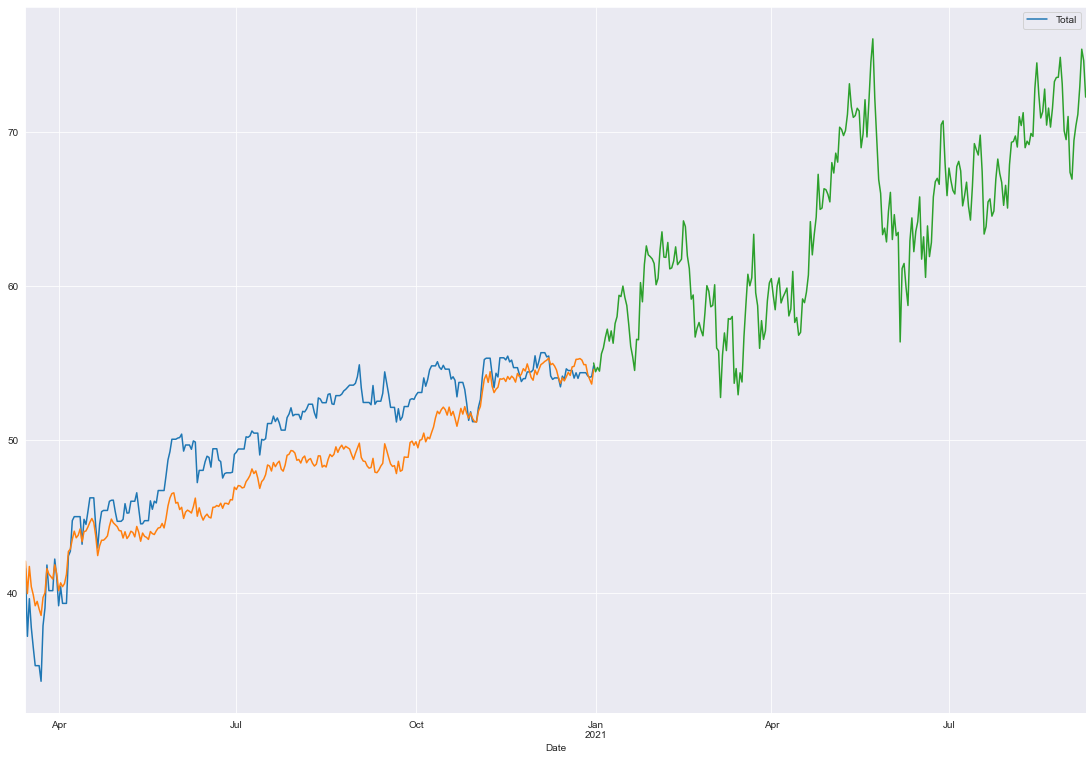

In [94]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [95]:
forecast

2020-12-31    54.981062
2021-01-01    54.414332
2021-01-02    54.694636
2021-01-03    54.453596
2021-01-04    55.578649
                ...    
2021-09-05    71.152307
2021-09-06    72.952776
2021-09-07    75.391086
2021-09-08    74.646890
2021-09-09    72.274796
Freq: D, Length: 253, dtype: float64

In [96]:
forecast_df = pd.DataFrame(forecast)

In [97]:
forecast_df

,0
2020-12-31,54.981062
2021-01-01,54.414332
2021-01-02,54.694636
2021-01-03,54.453596
2021-01-04,55.578649
...,...
2021-09-05,71.152307
2021-09-06,72.952776
2021-09-07,75.391086
2021-09-08,74.646890


In [98]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [99]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.010308
2021-01-02,-0.005210
2021-01-03,-0.009594
2021-01-04,0.010869
...,...
2021-09-05,0.294124
2021-09-06,0.326871
2021-09-07,0.371219
2021-09-08,0.357684


In [100]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  31.453984


## Backtesting

In [101]:
tickers2 = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [102]:
panel_data2 = panel_data2['Adj Close']

In [103]:
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV
Date,,,,,,,,,,,,,,,,,,,
2020-12-30,183.303909,192.874649,182.320007,117.758217,142.749680,30.581202,16.510557,62.400002,271.858215,358.480011,146.624527,487.229980,58.139999,15.175846,27.559999,103.190002,53.357380,193.660004,137.899994
2020-12-31,184.642197,194.428650,180.800003,119.217491,144.477020,30.600670,16.862049,62.720001,279.353760,358.350006,148.961548,485.051971,58.480000,15.098663,27.750000,104.070000,53.975620,194.979996,138.630005
2021-01-04,176.260925,189.955933,179.929993,116.387680,140.945999,30.279478,16.938046,59.500000,272.917725,348.059998,145.206696,497.264801,57.730000,14.432972,27.280001,103.730003,53.157955,192.020004,141.360001
2021-01-05,178.126678,191.011856,180.860001,117.008858,142.282059,30.600670,16.890549,59.419998,269.897705,345.700012,149.049515,502.595459,58.820000,14.375085,27.350000,104.830002,54.165073,195.690002,145.679993
2021-01-06,178.536942,192.555908,187.009995,121.337395,144.610657,30.201616,16.748051,60.610001,262.035858,329.660004,147.837051,487.538300,57.200001,14.124246,27.400000,106.239998,56.109516,205.479996,155.580002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,207.347183,347.977234,323.529999,163.778946,193.571014,55.196152,24.795002,105.820000,373.462097,663.080017,181.980865,801.409973,80.900002,20.666519,38.340000,124.959999,80.223610,307.929993,152.139999
2021-12-27,209.408127,355.260284,333.049988,163.978439,197.565552,55.852657,24.579479,107.790001,382.522247,697.000000,185.555954,811.429993,81.820000,21.160698,40.820000,126.360001,82.701866,307.619995,151.100006
2021-12-28,211.230103,356.299286,330.190002,163.998398,197.654755,55.176258,24.520700,107.720001,383.889252,682.200012,184.052231,804.770020,82.000000,20.824657,40.430000,125.360001,82.022346,306.049988,149.979996


## Portfolio Analysis

In [104]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV
Date,,,,,,,,,,,,,,,,,,,
2020-12-31,0.007301,0.008057,-0.008337,0.012392,0.012100,0.000637,0.021289,0.005128,0.027572,-0.000363,0.015939,-0.004470,0.005848,-0.005086,0.006894,0.008528,0.011587,0.006816,0.005294
2021-01-04,-0.045392,-0.023004,-0.004812,-0.023737,-0.024440,-0.010496,0.004507,-0.051339,-0.023039,-0.028715,-0.025207,0.025178,-0.012825,-0.044089,-0.016937,-0.003267,-0.015149,-0.015181,0.019693
2021-01-05,0.010585,0.005559,0.005169,0.005337,0.009479,0.010608,-0.002804,-0.001345,-0.011066,-0.006780,0.026464,0.010720,0.018881,-0.004011,0.002566,0.010604,0.018946,0.019113,0.030560
2021-01-06,0.002303,0.008084,0.034004,0.036993,0.016366,-0.013041,-0.008437,0.020027,-0.029129,-0.046399,-0.008135,-0.029959,-0.027542,-0.017450,0.001828,0.013450,0.035898,0.050028,0.067957
2021-01-07,-0.008316,0.044801,0.036790,-0.007910,0.019930,0.014180,0.044243,0.014684,0.002305,0.026755,0.029830,0.022867,0.024475,0.019126,0.015328,0.021931,0.031100,0.019321,0.046150


In [105]:
portfolio_weights = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV
Date,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000106,0.000552,-0.000059,0.000020,0.000149,0.000011,0.000277,0.000170,0.001983,-0.000003,3.873131e-07,-0.000046,0.000036,-0.000014,0.000011,0.000075,0.000077,0.000069,0.000024
2021-01-04,-0.000659,-0.001575,-0.000034,-0.000039,-0.000302,-0.000189,0.000059,-0.001699,-0.001657,-0.000264,-6.125266e-07,0.000261,-0.000078,-0.000122,-0.000027,-0.000029,-0.000101,-0.000153,0.000088
2021-01-05,0.000154,0.000381,0.000036,0.000009,0.000117,0.000191,-0.000037,-0.000044,-0.000796,-0.000062,6.430868e-07,0.000111,0.000115,-0.000011,0.000004,0.000093,0.000126,0.000193,0.000137
2021-01-06,0.000033,0.000553,0.000239,0.000061,0.000202,-0.000235,-0.000110,0.000663,-0.002094,-0.000426,-1.976716e-07,-0.000311,-0.000168,-0.000048,0.000003,0.000118,0.000239,0.000504,0.000305
2021-01-07,-0.000121,0.003067,0.000258,-0.000013,0.000246,0.000255,0.000576,0.000486,0.000166,0.000246,7.248680e-07,0.000237,0.000149,0.000053,0.000024,0.000192,0.000207,0.000195,0.000207


In [106]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31    0.003437
2021-01-04   -0.006517
2021-01-05    0.000717
2021-01-06   -0.000471
2021-01-07    0.006432
dtype: float64

Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,15.7%
Cumulative returns,15.7%
Annual volatility,4.7%
Sharpe ratio,3.12
Calmar ratio,7.65
Stability,0.97
Max drawdown,-2.1%


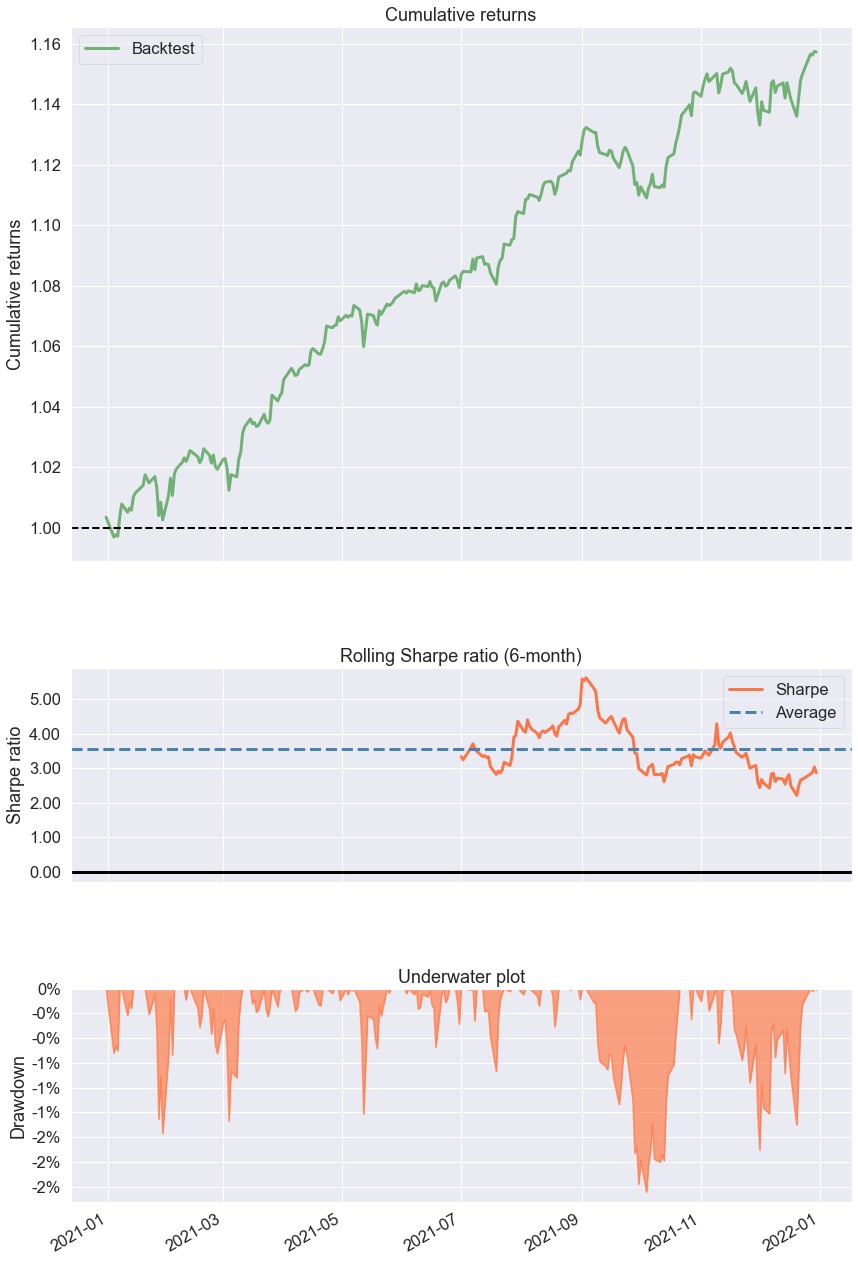

In [107]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [108]:
import itertools

In [109]:
weights = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

In [110]:
panel_data2 = panel_data2 * weights

In [111]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [112]:
#forecasted portfolio value
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total
Date,,,,,,,,,,,,,,,,,,,,
2020-12-30,2.660858,13.204777,1.280051,0.193895,1.762609,0.550104,0.214928,2.065190,19.547693,3.290309,0.003563,5.056716,0.354055,0.041835,0.043333,0.905554,0.355120,1.951163,0.619681,54.101434
2020-12-31,2.680285,13.311169,1.269379,0.196298,1.783937,0.550454,0.219503,2.075781,20.086653,3.289116,0.003620,5.034112,0.356126,0.041622,0.043631,0.913277,0.359235,1.964462,0.622962,54.801620
2021-01-04,2.558621,13.004953,1.263270,0.191638,1.740338,0.544676,0.220493,1.969212,19.623876,3.194669,0.003529,5.160863,0.351558,0.039787,0.042892,0.910293,0.353793,1.934640,0.635229,53.744331
2021-01-05,2.585705,13.077245,1.269800,0.192661,1.756835,0.550454,0.219874,1.966564,19.406725,3.173008,0.003622,5.216187,0.358196,0.039628,0.043002,0.919946,0.360496,1.971616,0.654642,53.766205
2021-01-06,2.591660,13.182955,1.312978,0.199788,1.785587,0.543276,0.218019,2.005949,18.841426,3.025784,0.003592,5.059916,0.348331,0.038936,0.043081,0.932320,0.373437,2.070252,0.699130,53.276419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,3.009872,23.823565,2.271472,0.269670,2.390128,0.992885,0.322771,3.502219,26.853419,6.086080,0.004422,8.317433,0.492657,0.056971,0.060282,1.096599,0.533928,3.102456,0.683672,83.870502
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,0.004509,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,0.004472,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542


In [113]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [114]:
actual_portfolio_value

[54.10143414003296,
 54.801620306328964,
 53.74433094588662,
 53.76620510521289,
 53.27641891147641,
 54.329039746978864,
 54.99251574327821,
 54.27539715975779,
 54.46207146697998,
 54.51148051595135,
 55.42246786942863,
 55.64349433384152,
 56.11608555680637,
 56.734976787991336,
 56.68874413754481,
 56.40945783058833,
 56.992415409120945,
 56.34402503850861,
 54.3977927139593,
 55.10435049163685,
 54.171301751631844,
 55.767552090566824,
 56.748373276789,
 55.38761890516834,
 56.3849312953354,
 56.70118711051226,
 56.90673397167836,
 57.1890327190258,
 56.80300558130435,
 57.10936781837596,
 57.50248920970228,
 56.99980524169807,
 56.59720378228168,
 56.80907309317875,
 57.31669327556305,
 56.597321373871424,
 55.83228941580333,
 56.501444299970345,
 55.99302025812864,
 55.83628862971487,
 56.226412766968345,
 56.12998551696827,
 55.36354563045615,
 53.744659374628256,
 54.91247062296179,
 54.50727824166497,
 55.881934309811776,
 56.112317627332615,
 57.44872663043576,
 57.893473429

In [115]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [116]:
forecasted_portfolio_value

[54.98106196663308,
 54.41433154235395,
 54.69463568939005,
 54.453596293802505,
 55.578648705818665,
 55.96314095136264,
 56.64659895197949,
 57.185597159144905,
 56.407400375326496,
 57.07207505841933,
 56.267534290319,
 57.552875206345945,
 58.000983368044764,
 59.38599198305205,
 59.301555915680176,
 59.986220340124326,
 59.24987570585259,
 58.71752021782332,
 57.46767946860635,
 56.05873113476017,
 55.39098510093502,
 54.49888425283065,
 56.52294294448591,
 56.49468983756757,
 60.213318496345146,
 58.96194592568602,
 61.3942458751778,
 62.59970732707672,
 62.01663599831941,
 61.89883083579168,
 61.75335769901143,
 61.4502540168536,
 60.07146475526257,
 60.49048057261597,
 62.30863150281581,
 63.513966411185116,
 61.87020026337985,
 61.8500132097448,
 62.8235812544789,
 61.10428682275874,
 61.16798790669821,
 61.61400025019514,
 62.5364198137773,
 61.378950818739234,
 61.551631471218734,
 61.73363152073627,
 64.22749594186268,
 63.85294541338799,
 61.9561034434904,
 61.129930747548

## Calculate MAPE of forecasted period

In [117]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.1
MAPE % : 10.17 %



## Mean Squared Error

In [134]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value)))

8.859159557768507


## Forecast for future

In [119]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


In [120]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-09,1.353398,3.829587,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265106,0.613491,...,1.112088,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,18.339691,-0.005068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


In [121]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [122]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [123]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361083,3.881017,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444282,0.584303,...,1.091921,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,18.496014,NaN
2017-01-04,1.368504,3.897117,0.316292,0.116782,0.811532,0.226310,0.170144,1.061720,7.454864,0.590728,...,1.086681,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,18.604857,0.005885
2017-01-05,1.370226,3.851053,0.308569,0.115342,0.805206,0.229835,0.169941,1.052784,7.356104,0.594308,...,1.099730,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,18.445237,-0.008579
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302492,0.613766,...,1.098544,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,18.433116,-0.000657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,85.688454,0.021676
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,85.610542,-0.000909
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,8.323349,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,85.925397,0.003678


In [124]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [125]:
tot_port_df

,Total
Date,
2017-01-03,18.496014
2017-01-04,18.604857
2017-01-05,18.445237
2017-01-06,18.433116
2017-01-07,18.433116
...,...
2021-12-27,85.688454
2021-12-28,85.610542
2021-12-29,85.925397


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


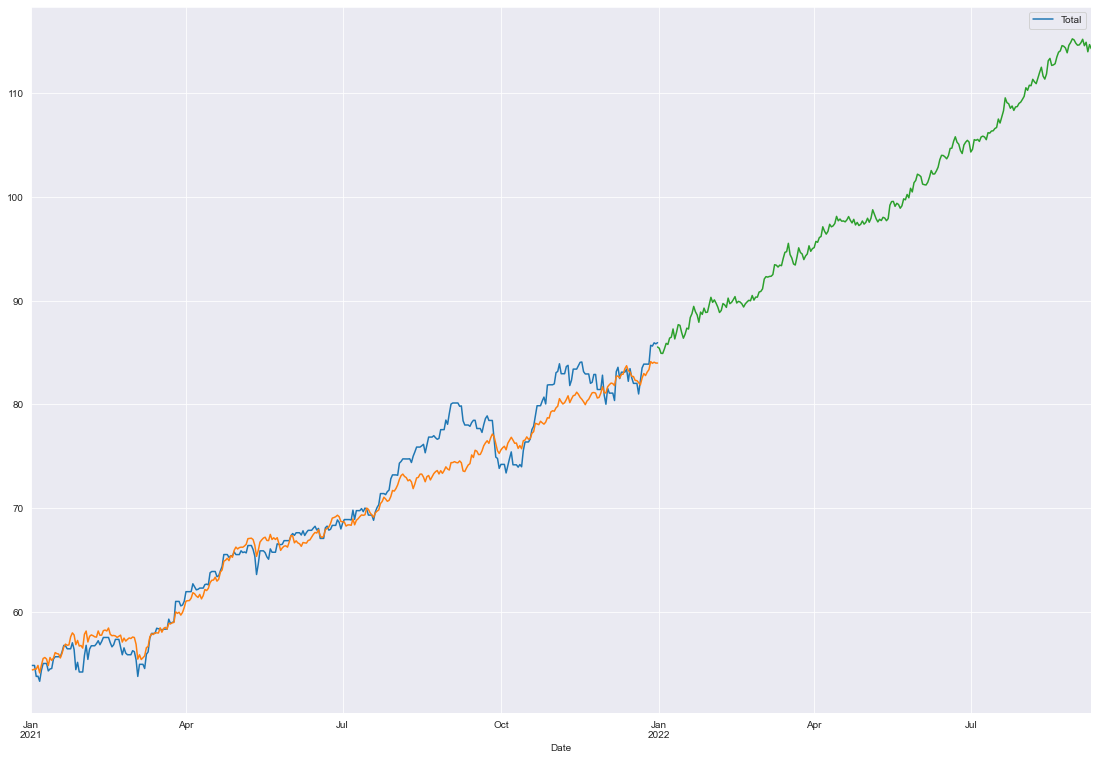

In [126]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [127]:
## Calculate annualized returns for forecasted

In [128]:
forecast

2021-12-31     85.523354
2022-01-01     85.403998
2022-01-02     84.915412
2022-01-03     84.900476
2022-01-04     85.347888
                 ...    
2022-09-05    114.589036
2022-09-06    114.921287
2022-09-07    114.002726
2022-09-08    114.696272
2022-09-09    114.293188
Freq: D, Length: 253, dtype: float64

In [129]:
forecast_df = pd.DataFrame(forecast)

In [130]:
forecast_df

,0
2021-12-31,85.523354
2022-01-01,85.403998
2022-01-02,84.915412
2022-01-03,84.900476
2022-01-04,85.347888
...,...
2022-09-05,114.589036
2022-09-06,114.921287
2022-09-07,114.002726
2022-09-08,114.696272


In [131]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [132]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.001396
2022-01-02,-0.007108
2022-01-03,-0.007283
2022-01-04,-0.002052
...,...
2022-09-05,0.339857
2022-09-06,0.343742
2022-09-07,0.333001
2022-09-08,0.341111


In [133]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                   0
2022-09-09  33.63974
